# Functions

In [62]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from numpy import linalg as LA
from sklearn.mixture import GaussianMixture
import seaborn as sns


In [3]:
D = 5
THETA = np.ones(D)/np.sqrt(D)

In [4]:
def create_dataset_symmetric_mixture (theta = THETA, d=D, n_1_unl=1000, n_2_unl=1000, n_1_labeled=10, n_2_labeled=10, sigma_1=1, sigma_2=1, seed=0):
  
  np.random.seed(seed)

  n_1 = n_1_unl + n_1_labeled
  n_2 = n_2_unl + n_2_labeled

  mu_1 =  theta
  mu_2 = - theta

  x_1 = sigma_1*np.random.randn(int(n_1), d) + mu_1[None, :]
  if n_1_labeled != 0:
    x_1_labeled = x_1[:n_1_labeled,:]
  else:
    x_1_labeled = None

  x_2 = sigma_2*np.random.randn(int(n_2), d) + mu_2[None, :]
  if n_2_labeled!= 0:
    x_2_labeled = x_2[:n_2_labeled,:]
  else:
    x_2_labeled = None

  if n_1_unl != 0:
    x_unlabeled = np.append(x_1[n_1_labeled:n_1,:], x_2[n_2_labeled:n_2,:], axis=0)
  else:
    x_unlabeled = None

  return x_1_labeled, x_2_labeled, x_unlabeled

In [5]:
def plot(x_1_labeled, x_2_labeled, x_unlabeled, W_OPT= np.ones(2)/np.sqrt(2), GAMMA=None , LIM=10):
  _, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim(-LIM, LIM)
  ax.set_ylim(-LIM, LIM)


  # opt & margin
  _x = np.linspace(-LIM, LIM, 100)
  _y = - W_OPT[0] * _x / W_OPT[1]
  ax.plot(_x, _y, c='black')

  if GAMMA is not None:
      ax.plot(_x, _y + GAMMA, c='grey')
      ax.plot(_x, _y - GAMMA, c='grey')


  ax.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], marker='.', c='lightblue', s=5)
  ax.scatter(x_1_labeled[:, 0],x_1_labeled[:, 1], marker='+', c='blue', s=20)
  ax.scatter(x_2_labeled[:, 0], x_2_labeled[:, 1], marker='_', c='red', s=20)

  plt.show()

In [58]:
x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100)

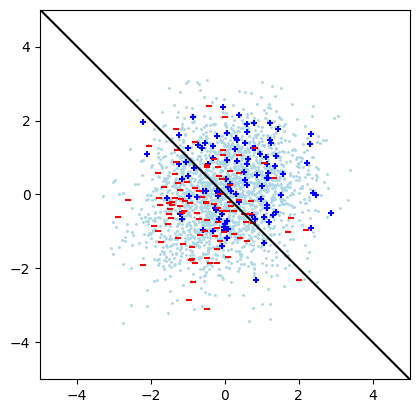

In [59]:
plot(x_1_labeled, x_2_labeled, x_unlabeled, LIM=5 )

In [24]:
def est_sup(x_1_labeled, x_2_labeled):
  return np.mean(np.append(x_1_labeled, -x_2_labeled, axis = 0), axis=0)

In [37]:
def unsup_est(x_unlabeled):
  unl_cov = np.transpose(x_unlabeled) @ x_unlabeled / x_unlabeled.shape[0]
  eigvals, eigvecs = LA.eigh(unl_cov)
  s = np.sqrt(eigvals[-1] - 1)
  v = eigvecs[:, -1]
  est_unl = s*v
  return est_unl


In [22]:
def expectation_maximization_kmeans_init(x_unlabeled=x_unlabeled):
  gm = GaussianMixture(n_components=2, random_state=0).fit(x_unlabeled)
  return gm.means_

In [89]:
def expectation_maximization_supervised_init(x_unlabeled=x_unlabeled,x_1_labeled= x_1_labeled, x_2_labeled= x_2_labeled ):
  mean_1 = np.mean(x_1_labeled, axis=0)
  mean_2 = np.mean(x_2_labeled, axis=0)
  means_init = np.append(mean_1[None, :], mean_2[None, :] ,axis=0)
  gm = GaussianMixture(n_components=2, random_state=0, means_init = means_init ).fit(x_unlabeled)
  return gm.means_

# Estimator in the upper-bound

In [60]:
exp_sup_error = []
exp_uns_error = []
exp_ssl_error = []
s_values = np.linspace(0,2,100)
for s in s_values:
  err_s = []
  err_u = []
  for seed in range(10):
    x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100, seed= seed)
    est_s = est_sup(x_1_labeled, x_2_labeled)
    est_u = unsup_est(x_unlabeled)
    err_s.append(np.linalg.norm(s*THETA - est_s)**2)
    err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(-s*THETA - est_u)])**2)

  exp_sup_error.append(np.mean(err_s))
  exp_uns_error.append(np.mean(err_u))

lamd_est_s = [exp_uns_error[i]/(exp_sup_error[i]+ exp_uns_error[i]) for i in range(len(exp_uns_error))]

exp_sup_error = []
exp_uns_error = []
exp_ssl_error = []

for ind, s in enumerate(s_values):
  err_s = []
  err_u = []
  err_ssl = []
  for seed in range(10, 20):
    x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100, seed= seed)
    est_s = est_sup(x_1_labeled, x_2_labeled)
    est_u = unsup_est(x_unlabeled)
    err_s.append(np.linalg.norm(s*THETA - est_s)**2)
    err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(s*THETA + est_u)])**2)
    err_ssl.append(min([np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s + (1-lamd_est_s[ind])*est_u )), np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s - (1-lamd_est_s[ind])*est_u ))])**2)

  exp_sup_error.append(np.mean(err_s))
  exp_uns_error.append(np.mean(err_u))
  exp_ssl_error.append(np.mean(err_ssl))

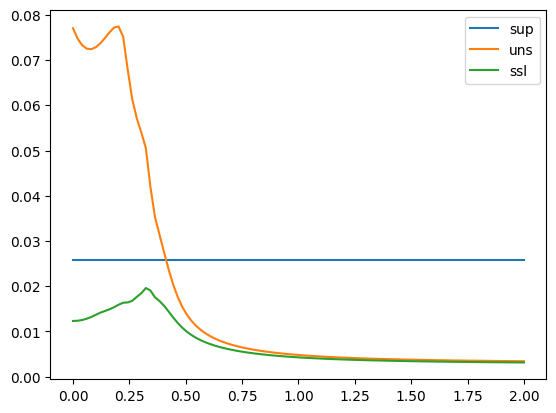

In [61]:
plt.plot(s_values,exp_sup_error, label="sup" )
plt.plot(s_values,exp_uns_error, label="uns" )
plt.plot(s_values,exp_ssl_error, label="ssl" )

plt.legend()

In [92]:
def plot_vary_s_fixed_dataset_size(n_l, n_u, uns_estimator_type= 'emp_cov', ssl_estimator_type='combined', num_weight_est_seed = 100, num_seed= 100):
  exp_sup_error = []
  exp_uns_error = []
  exp_ssl_error = []
  s_values = np.linspace(0,2,100)
  for s in s_values:
    err_s = []
    err_u = []
    for seed in range(num_weight_est_seed):
      x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=1000, n_2_unl=1000, n_1_labeled=100, n_2_labeled=100, seed= seed)
      est_s = est_sup(x_1_labeled, x_2_labeled)
      if uns_estimator_type=='emp_cov':
        est_u = unsup_est(x_unlabeled)
      elif uns_estimator_type=='EM':
        em_means = expectation_maximization_kmeans_init(x_unlabeled=x_unlabeled)
        est_u = em_means[0,:] - em_means[1,:]

      err_s.append(np.linalg.norm(s*THETA - est_s)**2)
      err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(-s*THETA - est_u)])**2)

    exp_sup_error.append(np.mean(err_s))
    exp_uns_error.append(np.mean(err_u))

  lamd_est_s = [exp_uns_error[i]/(exp_sup_error[i]+ exp_uns_error[i]) for i in range(len(exp_uns_error))]

  exp_sup_error = []
  exp_uns_error = []
  exp_ssl_error = []

  std_sup_error = []
  std_uns_error = []
  std_ssl_error = []

  for ind, s in enumerate(s_values):
    err_s = []
    err_u = []
    err_ssl = []
    for seed in range(num_weight_est_seed, num_weight_est_seed+num_seed):
      x_1_labeled, x_2_labeled, x_unlabeled = create_dataset_symmetric_mixture(theta=s*THETA, n_1_unl=int(n_u/2), n_2_unl=int(n_u/2), n_1_labeled=int(n_l/2), n_2_labeled=int(n_l/2), seed= seed)
      est_s = est_sup(x_1_labeled, x_2_labeled)
      if uns_estimator_type=='emp_cov':
        est_u = unsup_est(x_unlabeled)
      elif uns_estimator_type=='EM':
        em_means = expectation_maximization_kmeans_init(x_unlabeled=x_unlabeled)
        est_u = em_means[0,:] - em_means[1,:]
      
      if ssl_estimator_type=='EM_init':
        em_means = expectation_maximization_supervised_init(x_unlabeled=x_unlabeled,x_1_labeled= x_1_labeled, x_2_labeled= x_2_labeled )
      err_s.append(np.linalg.norm(s*THETA - est_s)**2)
      err_u.append(min([np.linalg.norm(s*THETA - est_u), np.linalg.norm(s*THETA + est_u)])**2)
      if ssl_estimator_type=='combined':
        err_ssl.append(min([np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s + (1-lamd_est_s[ind])*est_u )), np.linalg.norm(s*THETA - (lamd_est_s[ind]*est_s - (1-lamd_est_s[ind])*est_u ))])**2)
      elif ssl_estimator_type=='EM_init':
        err_ssl.append(min([np.linalg.norm(s*THETA - em_means[0,:]), np.linalg.norm(s*THETA - em_means[1,:])])**2)
    exp_sup_error.append(np.mean(err_s))
    exp_uns_error.append(np.mean(err_u))
    exp_ssl_error.append(np.mean(err_ssl))

    std_sup_error.append(np.std(err_s))
    std_uns_error.append(np.std(err_u))
    std_ssl_error.append(np.std(err_ssl))

  plt.figure()
  plt.plot(s_values,exp_sup_error, label="sup" , color='b')
  plt.fill_between(s_values, np.array(exp_sup_error)-np.array(std_sup_error), np.array(exp_sup_error)+np.array(std_sup_error), alpha=0.2, color='b')
  plt.plot(s_values,exp_uns_error, label="uns", color='g' )
  plt.fill_between(s_values, np.array(exp_uns_error)-np.array(std_uns_error), np.array(exp_uns_error)+np.array(std_uns_error), alpha=0.2, color='g')
  plt.plot(s_values,exp_ssl_error, label="ssl" , color='r')
  plt.fill_between(s_values, np.array(exp_ssl_error)-np.array(std_ssl_error), np.array(exp_ssl_error)+np.array(std_ssl_error), alpha=0.2, color='r')
  sns.despine()
  plt.title("$n_l=$"+str(n_l)+" $n_u=$"+str(n_u))
  plt.legend()

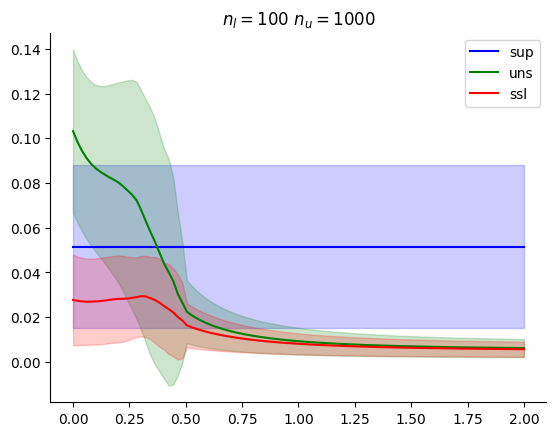

In [82]:
plot_vary_s_fixed_dataset_size(n_l=100, n_u=1000)

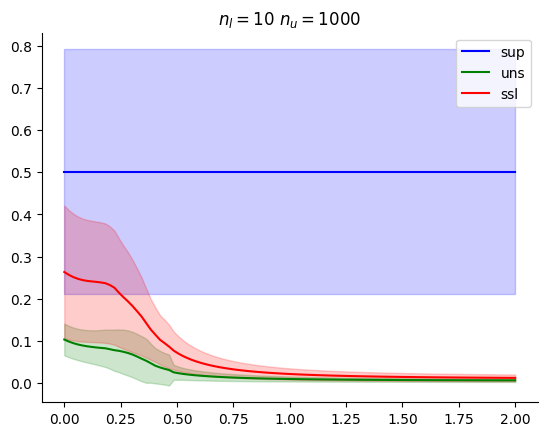

In [78]:
plot_vary_s_fixed_dataset_size(n_l=10, n_u=1000)

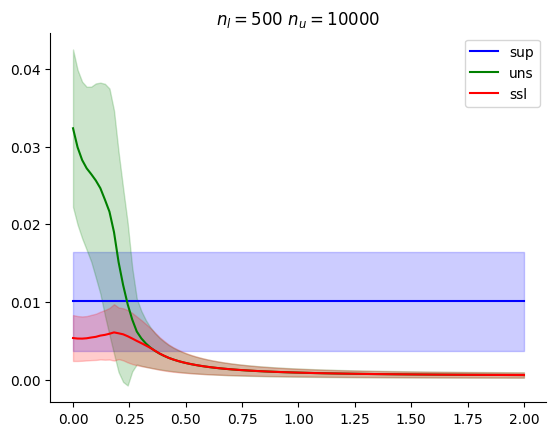

In [91]:
plot_vary_s_fixed_dataset_size(n_l=500, n_u=10000)

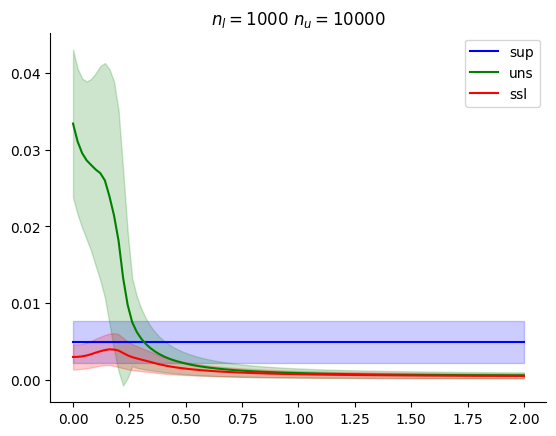

In [80]:
plot_vary_s_fixed_dataset_size(n_l=1000, n_u=10000)

# EM estimator with weighting in ssl

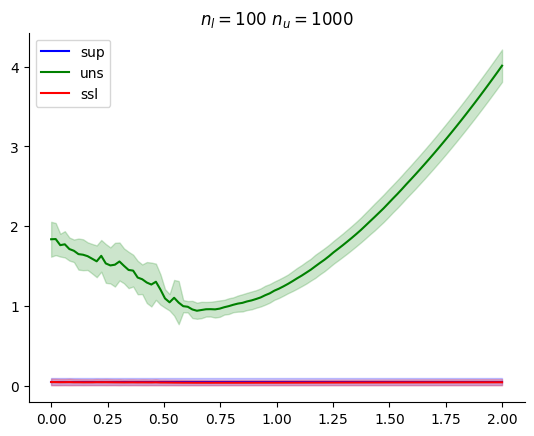

In [93]:
plot_vary_s_fixed_dataset_size(n_l=100, n_u=1000, uns_estimator_type='EM', num_weight_est_seed=10, num_seed=10)

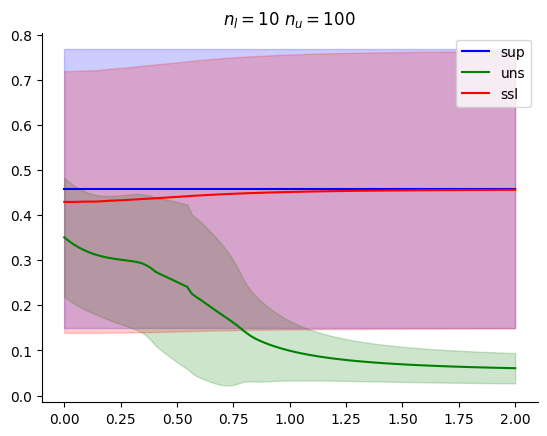

In [87]:
plot_vary_s_fixed_dataset_size(n_l=10, n_u=100, uns_estimator_type='EM', num_weight_est_seed=50, num_seed=50)

# EM with initialization using supervised samples

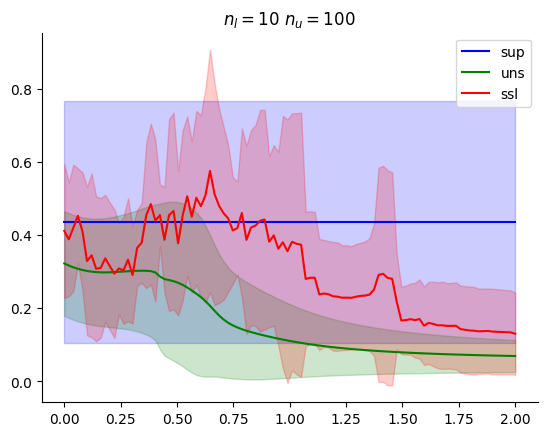

In [90]:
plot_vary_s_fixed_dataset_size(n_l=10, n_u=100, uns_estimator_type='EM', ssl_estimator_type='EM_init' ,num_weight_est_seed=1, num_seed=10)